# Enabling a RAG Model
see https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms

1. Download all pdfs from zenodo


In [1]:
import os
import pandas as pd
from natsort import natsorted
from caching import load_full_hf_cache, get_zenodo_pdfs
from pdf_utilities import download_all_pdfs
import matplotlib.pyplot as plt

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# Function to download all PDFs from the Training Material
download_all_pdfs(repo_name = "ScaDS-AI/SlideInsight_Cache", save_dir="zenodo_pdfs")

✅ All PDFs downloaded!


In [2]:
from byaldi import RAGMultiModalModel

# if CUDA is not available, change to device = "cpu"
docs_retrieval_model = RAGMultiModalModel.from_pretrained(pretrained_model_name_or_path = "vidore/colpali-v1.2", device = "cpu")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [1]:
# Function to index the pdfs from scratch
docs_retrieval_model.index(input_path="zenodo_pdfs/", index_name="pdf_index", store_collection_with_index=True, overwrite=True)

NameError: name 'docs_retrieval_model' is not defined

In [3]:
docs_retrieval_model = RAGMultiModalModel.from_index("pdf_index", device='cpu')

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 2534 images from 6 JSON files.


/home/lea/.local/lib/python3.10/site-packages/byaldi/colpali.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.indexed_embeddings.extend(torch.load(file))


In [4]:
text_query = "What means the By-Attribution in a License?"

k_results = 2
results = docs_retrieval_model.search(text_query, k=k_results)

In [5]:
from PIL import Image
import base64
from io import BytesIO

reconstructed_images = []

for result in results:
    base64_img = result["base64"]  
    image_data = base64.b64decode(base64_img)
    image = Image.open(BytesIO(image_data))
    reconstructed_images.append(image)

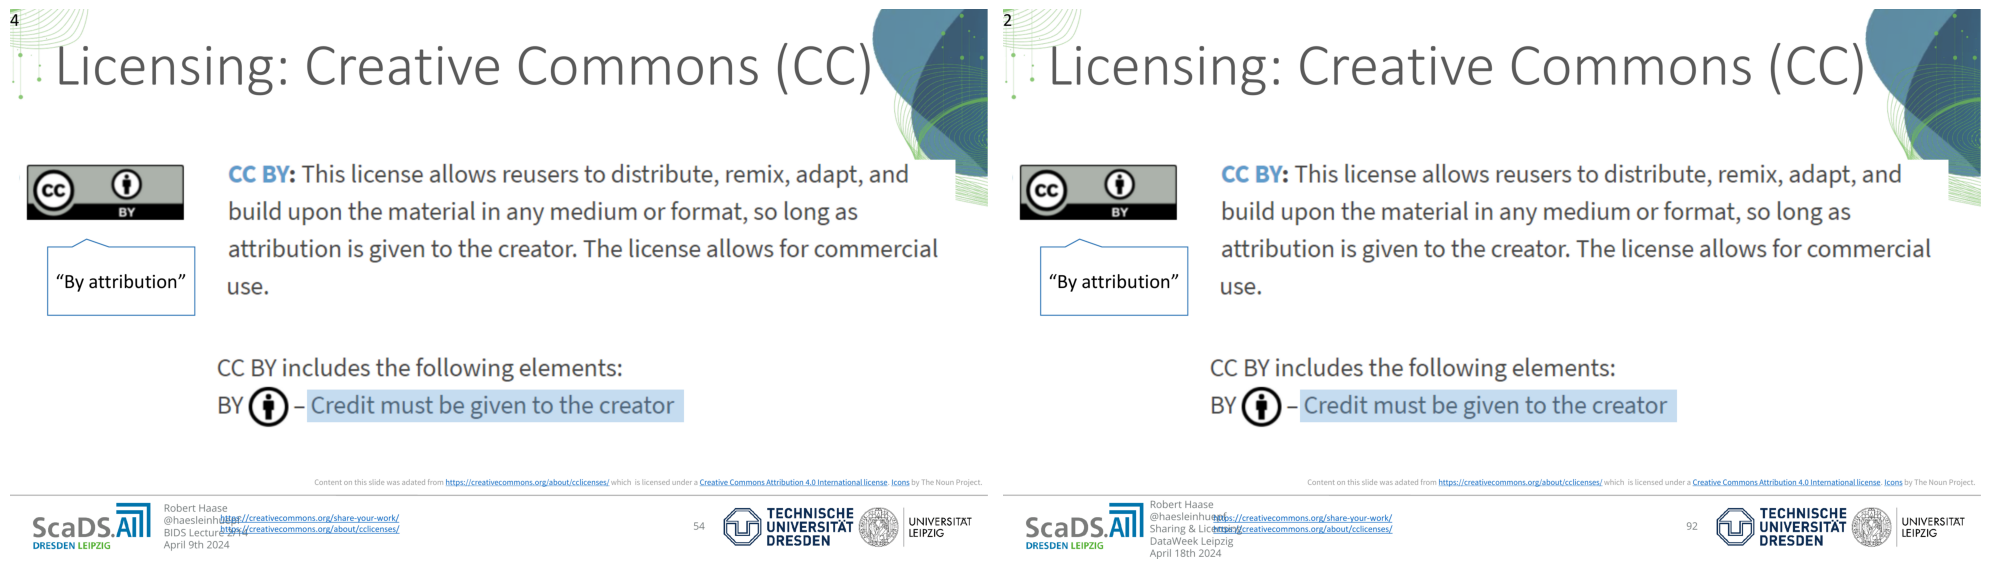

In [6]:
# Visualize
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(reconstructed_images), figsize=(20, 8))

for i, ax in enumerate(axes):
    ax.imshow(reconstructed_images[i])
    ax.axis("off")

plt.tight_layout()
plt.show()


## Now connect to the VLM Model, th generate some meaningful repsonses

In [7]:
from openai import OpenAI

# access the VLM via the SCADS API
my_api_key = os.getenv('SCADS_KEY')

In [9]:
client = OpenAI(base_url="https://llm.scads.ai/v1",api_key=my_api_key)

print("""Available models:""")
for model in client.models.list().data:
    print(model.id)

Available models:
openGPT-X/Teuken-7B-instruct-research-v0.4
Alibaba-NLP/gte-Qwen2-1.5B-instruct
en-de-translator
deepseek-ai/DeepSeek-Coder-V2-Lite-Instruct
meta-llama/Llama-3.3-70B-Instruct
Qwen/Qwen2-VL-7B-Instruct
deepseek-ai/DeepSeek-R1
tts-1-hd
meta-llama/Llama-4-Scout-17B-16E-Instruct


In [11]:
for model in client.models.list().data:
    model_name = model.id
    if "Llama-4-Scout" in model_name:
        break

### Convert the image content to a VLM message

In [17]:
def encode_pil_image(pil_img, max_size=(512, 512)):
    # Downsize the image (keeps aspect ratio)
    pil_img = pil_img.copy()
    pil_img.thumbnail(max_size)

    buffered = BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"


# Convert each image to base64 data URL format
image_contents = [
    {
        "type": "image_url",
        "image_url": {
            "url": encode_pil_image(img)
        }
    }
    for img in reconstructed_images
]

# Add the text query
image_contents.append({
    "type": "text",
    "text": f"{text_query}"
})

In [23]:
# Send the request to the VLM
response = client.chat.completions.create(
    model=model_name,
    messages=[
        {
            "role": "system",
            "content": "Try to anwser the following question using information from the given images. Also try to answer in a short, but precise manner",
            "role": "user",
            "content": image_contents
        }
    ],
    max_tokens=200
)

### Get the response

In [24]:
summary = response.choices[0].message.content
print(summary)

The By-Attribution in a License means that credit must be given to the creator. This is a requirement for using the material under the Creative Commons (CC) BY license, which allows reusers to distribute, remix, adapt, and build upon the material in any medium or format, as long as attribution is given to the creator. The license allows for commercial use.

In other words, By-Attribution refers to the need to provide attribution or credit to the original creator of the work when using, sharing, or adapting it. This is a key aspect of the CC BY license, which promotes the sharing and use of creative works while ensuring that the creators receive proper recognition for their work.
